# EDA, PCA & Clustering (TRAIN ONLY)

## Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

np.random.seed(42)


## Load cleaned training data

In [2]:
train_clean_path = "data/claims_test_clean.csv"
df = pd.read_csv(train_clean_path)

print("Shape:", df.shape)
df.head()


Shape: (135603, 12)


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1135885,0,1.00,E,5,8,46,50,B1,Regular,4116,R24
1,51280,0,0.24,D,4,10,46,64,B1,Regular,1329,R11
2,6112464,0,0.41,C,4,0,32,72,B12,Regular,377,R73
3,3245787,0,0.07,C,5,4,57,50,B2,Diesel,251,R93
4,168150,0,0.06,B,4,10,45,50,B2,Regular,94,R53


## Create claims risk variable

In [3]:
df["risk"] = df["ClaimNb"] / df["Exposure"]

df["risk"].describe()


count    135603.000000
mean          0.275059
std           5.204550
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         732.000000
Name: risk, dtype: float64

## Basic EDA: target distribution

Risk distribution


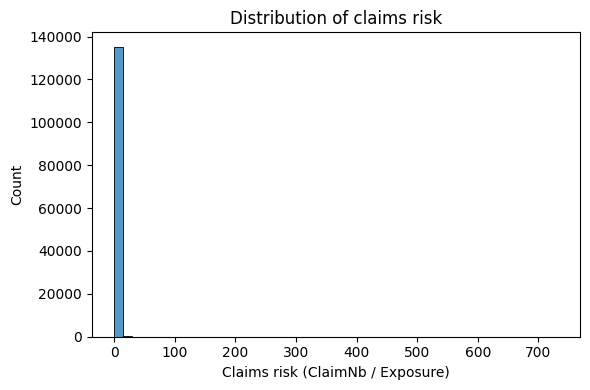

In [4]:
plt.figure(figsize=(6,4))
sns.histplot(df["risk"], bins=50, kde=False)
plt.xlabel("Claims risk (ClaimNb / Exposure)")
plt.ylabel("Count")
plt.title("Distribution of claims risk")
plt.tight_layout()
plt.show()


**Summary:** The distribution of claims risk is highly skewed, with the majority of policies exhibiting zero claims during the observation period. A small number of policies display very high risk values, typically corresponding to multiple claims within short exposure periods.

## Risk vs key numerical features

These plots help justify feature relevance.

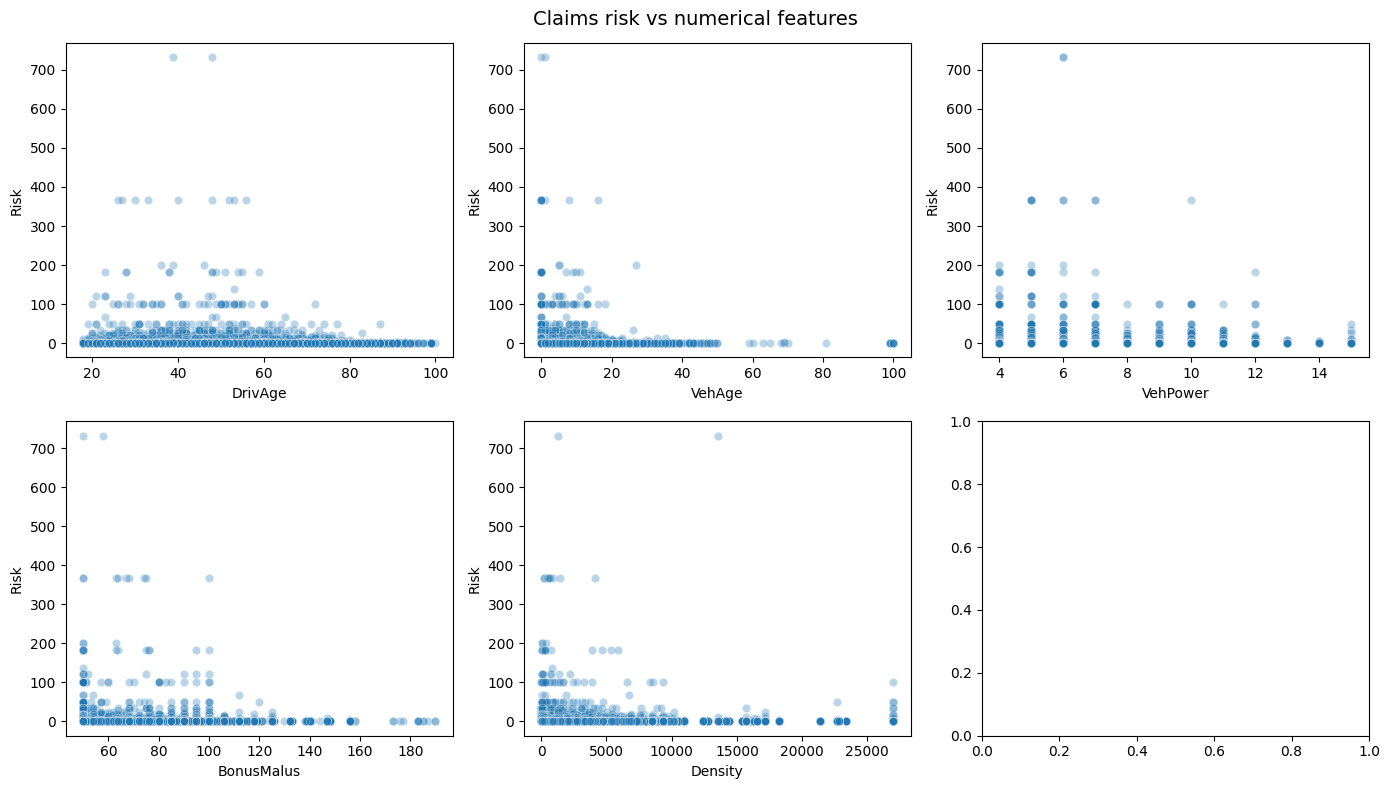

In [5]:
num_features = ["DrivAge", "VehAge", "VehPower", "BonusMalus", "Density"]

fig, axes = plt.subplots(2, 3, figsize=(14,8))
axes = axes.flatten()

for ax, col in zip(axes, num_features):
    sns.scatterplot(
        x=df[col],
        y=df["risk"],
        alpha=0.3,
        ax=ax
    )
    ax.set_xlabel(col)
    ax.set_ylabel("Risk")

fig.suptitle("Claims risk vs numerical features", fontsize=14)
plt.tight_layout()
plt.show()


**Summary:** Claims risk exhibits a highly skewed distribution with most observations concentrated near zero, while extreme values occur primarily for younger drivers, newer vehicles, lower bonus–malus scores, and lower population densities.

## Prepare data for PCA & clustering

We use numerical features only, and then we scale them.

In [6]:
pca_features = [
    "VehPower",
    "VehAge",
    "DrivAge",
    "BonusMalus",
    "Density"
]

X = df[pca_features].values


## Feature scaling

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled.mean(axis=0), X_scaled.std(axis=0)


(array([-5.63286536e-18,  5.81626097e-17,  1.76793374e-16,  8.38379960e-17,
         1.42524593e-17]),
 array([1., 1., 1., 1., 1.]))

Prior to applying PCA and k-means clustering, all numerical features were standardized to zero mean and unit variance to ensure equal contribution to distance- and variance-based methods.

## PCA

In [8]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance:", pca.explained_variance_ratio_.sum())


Explained variance ratio: [0.30289259 0.21939963]
Total explained variance: 0.5222922157915861


**Summary:**

- PC1 explains ~30%

- PC2 explains ~22%

Together ≈ 52% of total variance

The first two principal components explain approximately 52% of the total variance, indicating that while some structure is captured in two dimensions, a substantial amount of information remains in higher dimensions.

## PCA visualization

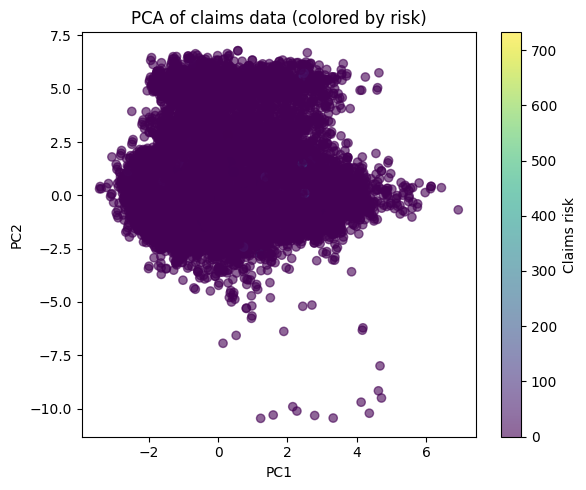

In [9]:
plt.figure(figsize=(6,5))
scatter = plt.scatter(
    X_pca[:,0],
    X_pca[:,1],
    c=df["risk"],
    cmap="viridis",
    alpha=0.6
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of claims data (colored by risk)")
plt.colorbar(scatter, label="Claims risk")
plt.tight_layout()
plt.show()


**Summary:**
Although the first two principal components explain approximately 52% of the variance, policies with high claims risk are not clearly separated in the reduced space, indicating that risk depends on complex, non-linear combinations of features.

## Log-color scale

Because risk is extremely skewed, we add a log-color scale

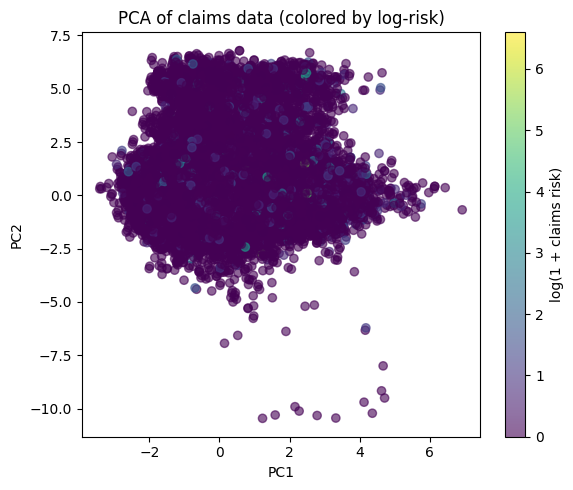

In [10]:
plt.figure(figsize=(6,5))
scatter = plt.scatter(
    X_pca[:,0],
    X_pca[:,1],
    c=np.log1p(df["risk"]),
    cmap="viridis",
    alpha=0.6
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of claims data (colored by log-risk)")
plt.colorbar(scatter, label="log(1 + claims risk)")
plt.tight_layout()
plt.show()


## K-means clustering

In [11]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df["cluster"] = clusters
df["cluster"].value_counts()


cluster
1    97550
0    34943
2     3110
Name: count, dtype: int64

The k-means algorithm produced three clusters of unequal but substantial size, indicating heterogeneity in policy characteristics rather than the presence of small outlier clusters.

## Clusters in PCA space

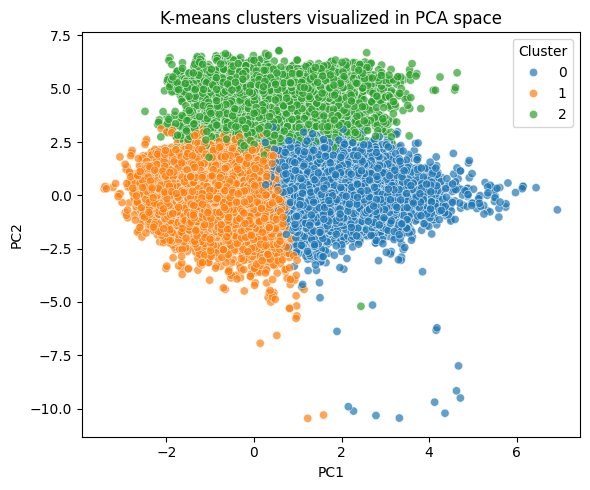

In [12]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=df["cluster"],
    palette="tab10",
    alpha=0.7
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-means clusters visualized in PCA space")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


**Summary:**

When visualized in PCA space, the clusters show partial separation, indicating that the numerical characteristics reflect a meaningful structure, although significant overlap remains.

## Interpret clusters

In [13]:
cluster_summary = (
    df.groupby("cluster")[pca_features + ["risk"]]
      .mean()
      .round(2)
)

cluster_summary


,VehPower,VehAge,DrivAge,BonusMalus,Density,risk
cluster,,,,,,
0,6.07,8.10,31.99,81.50,1581.82,0.35
1,6.58,6.74,50.28,51.88,1153.82,0.24
2,7.08,4.39,46.61,62.76,23534.78,0.52


**Interpretation:**

Cluster 0 corresponds to relatively young drivers operating in denser areas and exhibits the highest average claims risk.

Cluster 1 represents older drivers with newer vehicles and exhibits intermediate risk levels.

Cluster 2 contains policies associated with older vehicles and lower population densities and shows the lowest average claims risk.

### Severity Ranking Feature Engineering

We now engineer the severity ranking feature as computed in the 2-stage neural network model. This feature combines normalized ClaimNb and Exposure to create a risk score.

In [14]:
def minmax(series):
    """Min-max normalization with percentile clipping"""
    v = series.values.astype(float)
    lo, hi = np.percentile(v, 1), np.percentile(v, 99)
    v = np.clip(v, lo, hi)
    return (v - v.min()) / (v.max() - v.min() + 1e-9)

df['Norm_ClaimNb'] = minmax(df['ClaimNb'])
df['Norm_Exposure'] = minmax(df['Exposure'])
df['Norm_BonusMalus'] = minmax(df['BonusMalus'])

sev = ((1 * df['Norm_ClaimNb']) + (0.5 * df['Norm_Exposure']))
sev = (sev - sev.min()) / (sev.max() - sev.min() + 1e-9)
df['Severity'] = sev

print(f"Severity feature statistics:")
print(df['Severity'].describe())
print(f"\nSeverity range: [{df['Severity'].min():.4f}, {df['Severity'].max():.4f}]")

Severity feature statistics:
count    135603.000000
mean          0.208450
std           0.197124
min           0.000000
25%           0.057735
50%           0.165285
75%           0.333333
max           1.000000
Name: Severity, dtype: float64

Severity range: [0.0000, 1.0000]


### Correlation Analysis

We compute correlations between all variables and the target variables (ClaimNb, ClaimFlag) as well as the engineered Severity feature.

In [19]:
bm_min = df['BonusMalus'].min()
bm_max = df['BonusMalus'].max()

df['BM_Risk'] = (df['BonusMalus'] - bm_min) / (bm_max - bm_min)

df['LogDensity'] = np.log1p(df['Density'])

df['BadScore_BM_Dens'] = df['BM_Risk'] * df['LogDensity']

print("Additional engineered features:")
print("=" * 50)
print(f"BM_Risk - min: {df['BM_Risk'].min():.4f}, max: {df['BM_Risk'].max():.4f}, mean: {df['BM_Risk'].mean():.4f}")
print(f"LogDensity - min: {df['LogDensity'].min():.4f}, max: {df['LogDensity'].max():.4f}, mean: {df['LogDensity'].mean():.4f}")
print(f"BadScore_BM_Dens - min: {df['BadScore_BM_Dens'].min():.4f}, max: {df['BadScore_BM_Dens'].max():.4f}, mean: {df['BadScore_BM_Dens'].mean():.4f}")


Additional engineered features:
BM_Risk - min: 0.0000, max: 1.0000, mean: 0.0697
LogDensity - min: 0.6931, max: 10.2036, mean: 5.9881
BadScore_BM_Dens - min: 0.0000, max: 8.2185, mean: 0.4427


In [20]:
if 'ClaimFlag' not in df.columns:
    df['ClaimFlag'] = (df['ClaimNb'] > 0).astype(int)

correlation_features = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density',
                       'BM_Risk', 'LogDensity', 'BadScore_BM_Dens',
                       'ClaimNb', 'ClaimFlag', 'Severity']

corr_matrix = df[correlation_features].corr()

print("Correlation with ClaimNb:")
print("=" * 50)
print(corr_matrix['ClaimNb'].sort_values(ascending=False))
print("\n" + "=" * 50)
print("\nCorrelation with ClaimFlag:")
print("=" * 50)
print(corr_matrix['ClaimFlag'].sort_values(ascending=False))
print("\n" + "=" * 50)
print("\nCorrelation with Severity:")
print("=" * 50)
print(corr_matrix['Severity'].sort_values(ascending=False))


Correlation with ClaimNb:
ClaimNb             1.000000
ClaimFlag           0.949688
Severity            0.745266
BonusMalus          0.053703
BM_Risk             0.053703
BadScore_BM_Dens    0.052848
LogDensity          0.016076
DrivAge             0.011548
Density             0.008063
VehPower           -0.002661
VehAge             -0.019687
Name: ClaimNb, dtype: float64


Correlation with ClaimFlag:
ClaimFlag           1.000000
ClaimNb             0.949688
Severity            0.785385
BonusMalus          0.054005
BM_Risk             0.054005
BadScore_BM_Dens    0.052791
LogDensity          0.015064
DrivAge             0.012723
Density             0.008041
VehPower           -0.002326
VehAge             -0.020603
Name: ClaimFlag, dtype: float64


Correlation with Severity:
Severity            1.000000
ClaimFlag           0.785385
ClaimNb             0.745266
DrivAge             0.116446
VehAge              0.078611
VehPower           -0.027805
Density            -0.038170
LogDensity  

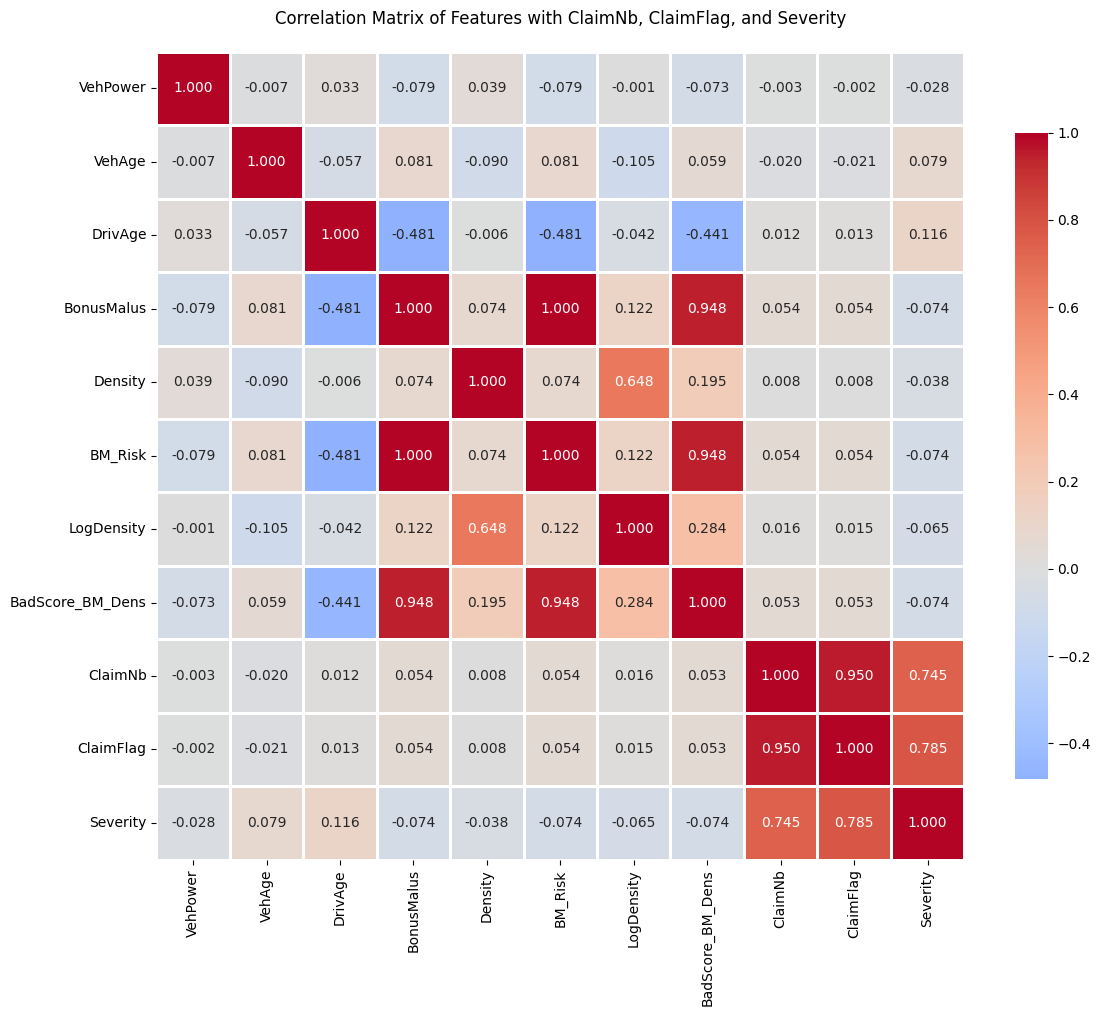

In [21]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Features with ClaimNb, ClaimFlag, and Severity', 
          fontsize=12, pad=20)
plt.tight_layout()
plt.show()


**Interpretation:**

The correlation analysis reveals the relationships between features and target variables:

- **Severity** is highly correlated with ClaimNb (by design, as it incorporates normalized ClaimNb)
- **ClaimFlag** captures the binary presence/absence of claims
- Other features show varying degrees of correlation with risk indicators

This analysis helps identify which features are most predictive of claims and can inform feature selection for predictive modeling.

### Conclusion


The exploratory analysis shows that claims risk is highly skewed, with most policies having zero claims and a small number exhibiting very high risk. PCA and clustering reveal some structure in the data, but high-risk policies are not clearly separable, indicating that risk depends on complex, non-linear feature interactions. These observations motivate the use of the severity target feature instead, as it provides a better target for possible models while still keeping most correlation to ClaimNb and ClaimFlag.